In [18]:
import netCDF4 as nc
import numpy as np

In [19]:
# read raw nc file
class NCTOTIFF:
    def __init__(self,path,mode):
        self._filepath = path
        self._mode = mode
        self._raw = None
        self._data = None
        self._lat = None
        self._lon = None
        self._nx, self._ny = None, None
        self._step_lon, self._step_lat = None, None

    def read(self):
        self._raw = nc.Dataset(self._filepath)
        if '10m' == self._mode:
            self._lat = self._raw.variables['latitude'][:]
            self._lon = self._raw.variables['longitude'][:]
        elif 'chl' == self._mode:
            self._lat = self._raw.variables['lat'][:]
            self._lat = self._lat[::10,::10]
            self._lon = self._raw.variables['lon'][:]
            self._lon = self._lon[::10,::10]
            
        else:
            self._lat = self._raw.variables['lat'][:]
            self._lon = self._raw.variables['lon'][:]
        self._latmin = np.min(self._lat)
        self._lonmin = np.min(self._lon)
        self._latmax = np.max(self._lat)
        self._lonmax = np.max(self._lon)

        if 'UNIST' in self._filepath:
            self._nx, self._ny = self._lon.shape[0], self._lat.shape[0]
            self._lonstep = (self._lon[-1] - self._lon[0]) / self._nx
            self._latstep = (self._lat[-1] - self._lat[0]) / self._ny
        elif self._mode == 'SSC':
            self._nx, self._ny = self._lon.shape[0], self._lat.shape[0]
            self._lonstep = (self._lon[-1] - self._lon[0]) / self._nx
            self._latstep = (self._lat[0] - self._lat[-1]) / self._ny
        elif self._mode == '10m':
            self._nx, self._ny = self._lon.shape[0], self._lat.shape[1]
            self._lonstep = (self._lon[-1,0] - self._lon[0,0]) / self._nx
            self._latstep = ( self._lat[0,0] - self._lat[0,-1] ) / self._ny
            self._lon = self._lon.T
            self._lat = self._lat.T[::-1,:]
        else:
            self._nx, self._ny = self._lon.shape[1], self._lat.shape[0]
            self._lat = self._lat[::-1,:]
            set_lon = int(self._nx/2)
            set_lat = int(self._ny/2)
            self._lonstep = (self._lon[set_lon,-1] - self._lon[set_lon,0]) / (self._nx-1)
            self._latstep = -(self._lat[-1,set_lat] - self._lat[0,set_lat]) / (self._ny-1)


        if self._mode == 'SST':
            interval = 'Daily' if 'Daily' in self._filepath else 'Hourly'
            self._data = self._raw.variables[f'{interval}_SST'][:]
        elif self._mode == 'SSS':
            self._data = self._raw.variables['DL_Interpolated_SSS'][:]
        elif self._mode == 'chl':
            self._data = self._raw.variables['merged_daily_Chl'][:]
            self._data = self._data[::10,::10]

            
        elif self._mode == '10m':
            self._time = self._raw.variables['time'][:]
            self._time = [self.julian_to_date(t) for t in self._time]
            self._data = self._raw.variables['10m salinity'][:]
        else:
            self._time = self._raw.variables['time'][:]
            self._time = [self.julian_to_date(t) for t in self._time]
            self._U = self._raw.variables['us'][:]
            self._V = self._raw.variables['vs'][:]

    def julian_to_date(self,julian):
        date = datetime.fromordinal(int(julian)) + timedelta(days=julian%1) - timedelta(days = 366)
        return date.strftime("%Y%m%d")

    def save(self):
        dirname = os.path.dirname(self._filepath)
        # make save folder
        if not os.path.exists(f'{dirname}/tif'):
            os.makedirs(f'{dirname}/tif')
        filename = os.path.basename(self._filepath).replace('.nc','.tif')
        
        if not 'PNU' in self._filepath:
            savepath = f'{dirname}/tif/{filename}'
            self._data.fill_value=-9999

            with rasterio.open(savepath, 'w', 
                        driver='GTiff', 
                        height=self._data.shape[0],
                        width=self._data.shape[1],
                        count=1, 
                        dtype=self._data.dtype,
                        crs='EPSG:4326', 
                        transform=rasterio.transform.from_origin(self._lonmin,self._latmin,self._lonstep,self._latstep),
                        ) as dst:
                dst.write(self._data, 1)
        
        elif self._mode == 'SSC':
            for i in range(len(self._time)):
                date = self._time[i]
                U = self._U[i,:,:]
                U = U[::-1,:]
                V = self._V[i,:,:]
                V = V[::-1,:]
                speed_data = np.sqrt(U**2+V**2)
                _data = (np.arctan2(V,-U)*(180/np.pi)+90)%360
                _data.fill_value=-9999
                savepath = f'{dirname}/tif/{date}_{filename}'
                with rasterio.open(savepath, 'w', 
                                driver='GTiff', 
                                height=_data.shape[0],
                                width=_data.shape[1],
                                count=2, 
                                dtype=_data.dtype,
                                crs='EPSG:4326', 
                                transform=rasterio.transform.from_origin(self._lonmin,self._latmin,self._lonstep,self._latstep),
                                ) as dst:
                    dst.write(speed_data, 1)
                    dst.write(_data, 2)
        
            
        else:
            for i in range(len(self._time)):
                date = self._time[i]
                _data = self._data[i,:,:]
                if self._mode == '10m':
                    _data = _data.T
                    _data = _data[::-1,:]
                _data.fill_value=-9999

                savepath = f'{dirname}/tif/{date}_{filename}'


                with rasterio.open(savepath, 'w', 
                                driver='GTiff', 
                                height=_data.shape[0],
                                width=_data.shape[1],
                                count=1, 
                                dtype=_data.dtype,
                                crs='EPSG:4326', 
                                transform=rasterio.transform.from_origin(self._lonmin,self._latmin,self._lonstep,self._latstep),
                                ) as dst:
                    dst.write(_data, 1)


In [20]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


In [21]:
# read data

TEST = NCTOTIFF('/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/chl/UST21_L3_Merged-Chla-1D_20200901.nc','chl')
TEST.read()

val = TEST._data
lat = TEST._lat[::-1]
lon = TEST._lon

In [22]:
val.shape

(800, 1050)

/tmp/ipykernel_29948/3996330910.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon, lat, val, cmap='jet')


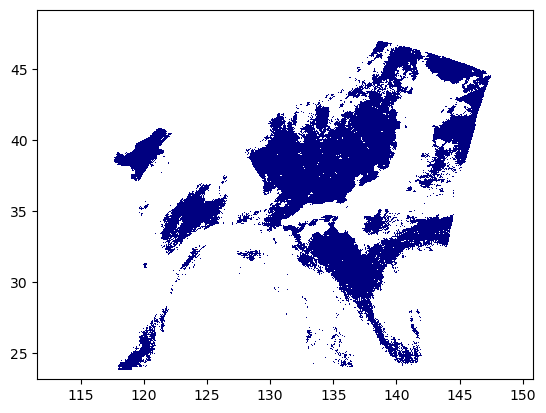

In [23]:
plt.pcolormesh(lon, lat, val, cmap='jet')

In [24]:
latmin = np.min(lat)
lonmin = np.min(lon)
latmax = np.max(lat)
lonmax = np.max(lon)

nx, ny = lon.shape[0], lat.shape[0]
lon_grid = np.linspace(lonmin, lonmax, nx)
lat_grid = np.linspace(latmin, latmax, ny)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

points = np.column_stack((lon.ravel(), lat.ravel()))
values = val.ravel()

# mapping to new grid
vis_vals = griddata(points, values, (lon_grid, lat_grid), method='nearest')


In [25]:
lon_grid

array([[111.60403442, 111.65311196, 111.7021895 , ..., 150.71883101,
        150.76790855, 150.81698608],
       [111.60403442, 111.65311196, 111.7021895 , ..., 150.71883101,
        150.76790855, 150.81698608],
       [111.60403442, 111.65311196, 111.7021895 , ..., 150.71883101,
        150.76790855, 150.81698608],
       ...,
       [111.60403442, 111.65311196, 111.7021895 , ..., 150.71883101,
        150.76790855, 150.81698608],
       [111.60403442, 111.65311196, 111.7021895 , ..., 150.71883101,
        150.76790855, 150.81698608],
       [111.60403442, 111.65311196, 111.7021895 , ..., 150.71883101,
        150.76790855, 150.81698608]])

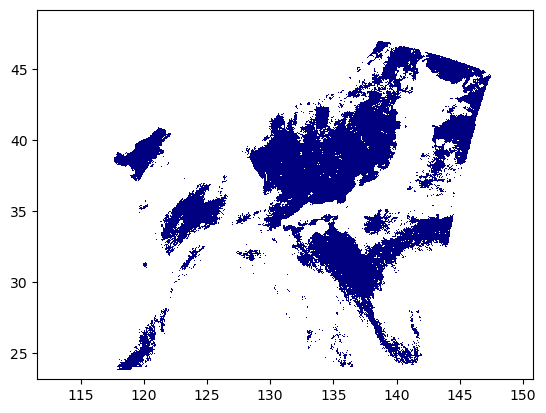

In [26]:
plt.pcolormesh(lon_grid, lat_grid, vis_vals, cmap='jet')

800 800
(800, 800)
(800, 800)
(800, 800)


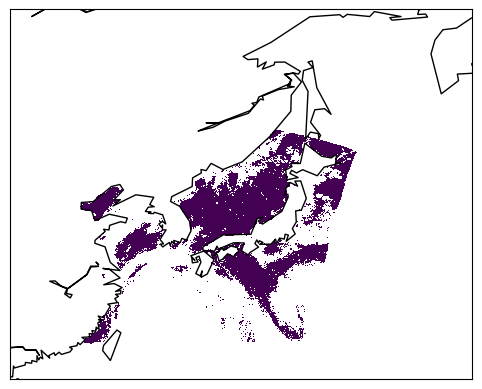

In [27]:
import numpy as np

# 데이터 다운샘플링 및 격자 생성 함수
def downsample_data_and_grid(data, lat, lon, resolution):
    # NaN 값을 -inf로 대체
    data = np.where(np.isnan(data), -np.inf, data)

    # 데이터 및 격자 재구조화
    ny, nx = data.shape
    new_ny, new_nx = ny // resolution, nx // resolution
    
    print(new_ny, new_nx)
    
    reshaped_data = data[:new_ny*resolution, :new_nx*resolution].reshape(new_ny, resolution, new_nx, resolution)
    reshaped_lat = lat[:new_ny*resolution, :new_nx*resolution].reshape(new_ny, resolution, new_nx, resolution)
    reshaped_lon = lon[:new_ny*resolution, :new_nx*resolution].reshape(new_ny, resolution, new_nx, resolution)

    # 각 블록의 최대값 및 평균 위치 계산
    downsampled_data = np.nanmax(reshaped_data, axis=(1, 3))
    downsampled_lat = np.nanmean(reshaped_lat, axis=(1, 3))
    downsampled_lon = np.nanmean(reshaped_lon, axis=(1, 3))

    return downsampled_data, downsampled_lat, downsampled_lon

# 해상도 설정 (예: 10)
resolution = 1

# val, lat, lon 데이터에 대한 해상도 변경
downsampled_val, downsampled_lat, downsampled_lon = downsample_data_and_grid(vis_vals, lat_grid, lon_grid, resolution)

print(downsampled_val.shape)
print(downsampled_lat.shape)
print(downsampled_lon.shape)

m = Basemap(projection='cyl',resolution='c', llcrnrlat=20, urcrnrlat=60, llcrnrlon=110, urcrnrlon=160)
m.drawcoastlines()
x,y = m(downsampled_lon,downsampled_lat)
m.pcolormesh(x,y,downsampled_val,cmap='viridis')

In [28]:
import rasterio

In [29]:
lonmin = np.min(downsampled_lon)
latmin = np.min(downsampled_lat)
latmax = np.max(downsampled_lat)
lon_step = (np.max(downsampled_lon)-np.min(downsampled_lon)) / downsampled_lon.shape[1]
lat_step = (np.max(downsampled_lat)-np.min(downsampled_lat)) / downsampled_lat.shape[0]

In [36]:
import glob
import os

In [32]:
mode = 'chl'
fpath ='/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/chl'

In [37]:
filelist = glob.glob(f'{fpath}/*.nc')

In [39]:
for f in filelist:
    print(f)
    nctotiff = NCTOTIFF(f,mode)
    nctotiff.read()
    val = nctotiff._data
    lat = nctotiff._lat[::-1]
    lon = nctotiff._lon
    latmin = np.min(lat)
    lonmin = np.min(lon)
    latmax = np.max(lat)
    lonmax = np.max(lon)

    nx, ny = lon.shape[0], lat.shape[0]
    lon_grid = np.linspace(lonmin, lonmax, nx)
    lat_grid = np.linspace(latmin, latmax, ny)
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

    points = np.column_stack((lon.ravel(), lat.ravel()))
    values = val.ravel()

    # mapping to new grid
    vis_vals = griddata(points, values, (lon_grid, lat_grid), method='nearest')

    # 해상도 설정 (예: 10)
    resolution = 1

    # val, lat, lon 데이터에 대한 해상도 변경
    downsampled_val, downsampled_lat, downsampled_lon = downsample_data_and_grid(vis_vals, lat_grid, lon_grid, resolution)

    lonmin = np.min(downsampled_lon)
    latmin = np.min(downsampled_lat)
    latmax = np.max(downsampled_lat)
    lon_step = (np.max(downsampled_lon)-np.min(downsampled_lon)) / downsampled_lon.shape[1]
    lat_step = (np.max(downsampled_lat)-np.min(downsampled_lat)) / downsampled_lat.shape[0]

    filename = os.path.basename(f).replace('.nc','.tif')

    with rasterio.open('/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/LAST/chl/'+filename, 'w', 
                        driver='GTiff', 
                        height=downsampled_val.shape[0],
                        width=downsampled_val.shape[1],
                        count=1, 
                        dtype=downsampled_val.dtype,
                        crs='EPSG:4326', 
                        transform=rasterio.transform.from_origin(lonmin,latmax,lon_step,lat_step),
                        ) as dst:
                dst.write(downsampled_val[::-1], 1)

    

/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/chl/UST21_L3_Merged-Chla-1D_20200902.nc
800 800
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/chl/UST21_L3_Merged-Chla-1D_20200901.nc
800 800
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/chl/UST21_L3_Merged-Chla-1D_20200903.nc
800 800
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/chl/UST21_L3_Merged-Chla-1D_20200904.nc
800 800
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/chl/UST21_L3_Merged-Chla-1D_20200905.nc
800 800
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/chl/UST21_L3_Merged-Chla-1D_20200906.nc
800 800
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/chl/UST21_L3_Merged-Chla-1D_20200907.nc
800 800
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/chl/UST21_L3_Merged-Chla-1D_20200908.nc
800 800
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/chl/UST21_L3_Merged-Chla-1D_20200909.nc
800 800
/home/nifs_big/model_web_yj/geo-modelweb/Data/MODEL/new/chl/UST2

In [ ]:
lonmin = np.min(downsampled_lon)
latmin = np.min(downsampled_lat)
latmax = np.max(downsampled_lat)
lon_step = (np.max(downsampled_lon)-np.min(downsampled_lon)) / downsampled_lon.shape[1]
lat_step = (np.max(downsampled_lat)-np.min(downsampled_lat)) / downsampled_lat.shape[0]

In [30]:
lat_step

0.03245280742645264

In [31]:
with rasterio.open('./test.tif', 'w', 
                        driver='GTiff', 
                        height=downsampled_val.shape[0],
                        width=downsampled_val.shape[1],
                        count=1, 
                        dtype=downsampled_val.dtype,
                        crs='EPSG:4326', 
                        transform=rasterio.transform.from_origin(lonmin,latmax,lon_step,lat_step),
                        ) as dst:
                dst.write(downsampled_val[::-1], 1)